## Packages and Presets

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

import torch
from skimpy import clean_columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from pickle import load
import shap
from torch.utils.data import DataLoader

#from neural_additive_model import NAM
from mlp import MLP
import torch.nn as nn

import sys

sys.path.append("../..")
from utils.utils import (
    set_all_seeds,
    test,
    get_n_units,
    HeartFailureDataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    penalized_binary_cross_entropy,
)

import warnings
warnings.filterwarnings("ignore")

In [16]:
SEED = 123
GRID_SIZE = 10_000

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 1_000


HIDDEN_PROFILE = [1024]
USE_EXU = False
USE_RELU_N = False
WITHIN_FEATURE_DROPOUT = 0.4
FEATURE_DROPOUT = 0.0

# number of models to train in the multiple models section
N_MODELS = 20

LEARNING_RATE = 0.003

SCHEDULER_STEP_SIZE = 10
SCHEDULER_GAMMA = 0.9

OPTIMIZER = torch.optim.Adam
CRITERION = penalized_binary_cross_entropy

OUTPUT_REGULARIZATION = 0.0058
L2_REGULARIZATION = 3.87e-5

EARLY_STOPPING_START = 60

## Loading Data and Model

In [17]:
train_df = pd.read_csv("../data/heart_failure/train_val_split.csv").pipe(
    clean_columns
)
X_train = train_df.drop(columns=["heart_disease"], axis=1)
outlier_idx = X_train.query("resting_bp == 0").index
print(f"{outlier_idx=}")
X_train = X_train.drop(outlier_idx)
y_train = train_df["heart_disease"]
y_train = y_train[X_train.index]

# create categorical variable for cholesterol level
X_train["chol_level"] = pd.cut(
    X_train["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)

outlier_idx=Index([366], dtype='int64')


We also have to load the test (X) data as they will be used later for the SHAP values:

In [18]:
test_df = pd.read_csv("../data/heart_failure/test_split.csv").pipe(clean_columns)
X_test = test_df.drop(columns=["heart_disease"], axis=1)
# create categorical variable for cholesterol
X_test["chol_level"] = pd.cut(
    X_test["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)
y_test = test_df["heart_disease"]

In [19]:
X_models_train, X_models_val, y_models_train, y_models_val = train_test_split(
    X_train,
    y_train.to_numpy(),
    test_size=0.2,
    shuffle=True,
    random_state=SEED,
    stratify=y_train.to_numpy(),
)

In [20]:
preprocessor = load(open("../models/preprocessor.pkl", "rb"))

categorical_cols = [col for col in X_train.columns if X_train.nunique()[col] < 5]
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_models_train)
X_val_preprocessed = preprocessor.transform(X_models_val)
X_test_preprocessed = preprocessor.transform(X_test)

In [21]:
set_all_seeds(SEED)
pretrained_mlp = torch.load("../models/mlp.pth")

## Performance Metrics

In [22]:
test_dataset = HeartFailureDataset(X_test_preprocessed, y_test.to_numpy())
test_loader = DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True
)


In [30]:

test_loss, test_f1_score, balanced_accuracy, model_probs, y_true = test(
    model=pretrained_mlp,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),
    device=DEVICE,
    use_penalized_BCE=False,
    output_regularization=OUTPUT_REGULARIZATION,
    l2_regularization=L2_REGULARIZATION,
)

Test Loss: 0.38983185589313507
Test F1 Score: 0.8468468468468469
Test Balanced Accuracy: 0.8056511056511056


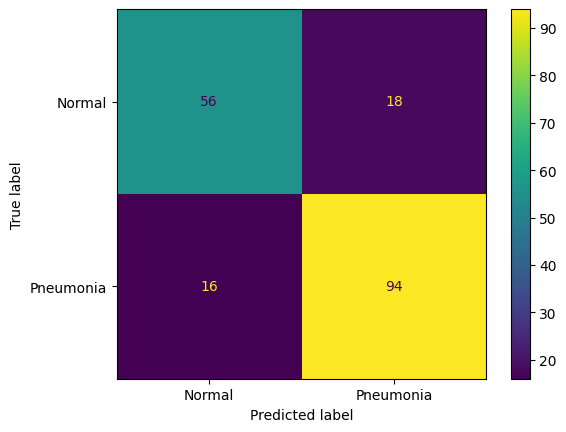

In [31]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [32]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

roc_auc = roc_auc_score(y_true, model_probs)


print(f"Accuracy of the model is {accuracy:.3f}")
print(f"Balanced accuracy of the model is {balanced_accuracy:.3f}")
print(f"Recall of the model is {recall:.3f}")
print(f"Precision of the model is {precision:.3f}")
print(f"F1 Score of the model is {test_f1_score:.3f}")
print(f"ROC AUC of the model is {roc_auc:.3f}")

Accuracy of the model is 0.815
Balanced accuracy of the model is 0.806
Recall of the model is 0.855
Precision of the model is 0.839
F1 Score of the model is 0.847
ROC AUC of the model is 0.891
